In [130]:
import logging
class Complex():
    """
    A class relating the vertexes of a hypercomplex of hypersimplices without
    physical storage by exploiting the symmetry of the simplicial powerset.
    """
    def __init__(self, dim=2):
        import numpy
        self.V = []
        self.S = []  # Face indexes, edges = 1 face
        self.I = []  # Index sets
        self.i_gen = [] 
        self.i_current = [] 
        for i in range(dim + 1):
            self.S.append([])
            self.I.append([])
            self.i_gen.append(self.index_gen())     
            self.i_current.append(0)  
            
        #self.I_V = numpy.linspace(0, dim**2)
        
        # Intiate first generation of vertices
        #V      
            
    def n_cube(self, dim, printout=False):
        """
        Generate the simplicial triangulation of the n cube
        containing 2**n vertices
        """
        import math
        import numpy

        permgroups = list(itertools.permutations(range(dim)))
        permgroups
        # Build the D set feasible region to use for symmetery groups later:
        D = [[0, 1],]*dim  # Domain := hypercube
        D = numpy.array(D)

        S = []
        for tau in permgroups:  # n! simplices
            V = numpy.tile(D[:, 0], (dim + 1, 1))

            for i in range(dim):
                for j in range(dim):
                    V[i + 1] = V[i]  # (Needed since looping through i will use these)

                tau[i]
                V[i + 1][tau[i]] = D[tau[i], 1]

            #TODO: Loop and identify vertices
            S.append(V)
            
        if printout:
            for i, tau in enumerate(permgroups):
                print('Tau: {}'.format(tau))
                print('Simpex {}:'.format(i))
                print(S[i])
                
        return S
        
    def generate_vertex(self, x):
        """
        x: vector of cartesian coordinates
        """
        self.V.append(x)
        self.i_current[0] = next(self.i_gen[0])
        logging.info('self.i_current[0] = {}'.format(self.i_current[0]))
        self.I[0].append(self.i_current[0])
        
        
    def generate_simplex(self, V_i, k=1):
        """
        V_i: Tuple containing the indexes of vertices to connect
        """
        self.S[k].append(V_i)
        self.i_current[k] = next(self.i_gen[k])  
        logging.info('self.i_current[k] = {}'.format(self.i_current[k]))
        self.I[k].append(self.i_current[k])
        
    def destroy_simplex(self, ind):
        """
        Delete faces from lists to free up memory
        """
            
    def index_gen(self):
        ind = 0
        while True:
            yield ind
            ind += 1
            
    # incidence arrays
    
    # plots
    def plot_vertexes(self, V):
        return
    
    def plot_graph(self):
        from matplotlib import pyplot
        %matplotlib nbagg
        pyplot.figure()
        for v in HC.V:
            pyplot.plot([v[0]], [v[1]], 'o')

        for f in HC.S[1]:
            #print(HC.V[f[0]], HC.V[f[1]])
            pyplot.plot([HC.V[f[0]][0], HC.V[f[1]][0]],
                          [HC.V[f[0]][1], HC.V[f[1]][1]], 'r-')

        pyplot.ylim([-1e-2, 1+1e-2])
        pyplot.xlim([-1e-2, 1+1e-2])
        pyplot.show()
        return
       
    def plot_complex_3dim(self, S):
        """
        Here S is the LIST of simplexes in the 3 dimension complex 
        
        To plot a single simplex in a set S, use ex. [S[0]]
        """
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        for s in S:
            x = []
            y = []
            z = []
            for v in range(4):
                x.append(s[v, 0])
                y.append(s[v, 1])
                z.append(s[v, 2])

            # Lines from first with thrid vertex
            x.append(s[0][0])
            y.append(s[0][1])
            z.append(s[0][2])
            x.append(s[2][0])
            y.append(s[2][1])
            z.append(s[2][2])
            # Lines from last to second vertex
            x.append(s[3][0])
            y.append(s[3][1])
            z.append(s[3][2])
            x.append(s[1][0])
            y.append(s[1][1])
            z.append(s[1][2])

            ax.plot(x, y, z, label='simplex')
         
        return

        
    def print_complex(self):
        print('Index set I = {}'.format(self.I))
        print('Vertices V = {}'.format(self.V))
        print('Simplices S = {}'.format(self.S))
            
HC = Complex()
HC.I

#HC.index_gen()
#index = HC.index_gen()
next(HC.i_gen[0]), next(HC.i_gen[0]), next(HC.i_gen[1]), next(HC.i_gen[0]), next(HC.i_gen[1])

(0, 1, 0, 2, 1)

In [135]:
HC = Complex()
HC.I
HC.generate_vertex([0, 0])  # 0
HC.generate_vertex([0, 1])  # 1
HC.generate_vertex([1, 0])  # 2
HC.generate_vertex([1, 1])  # 3
#HC.generate_vertex([0.5, 0.5])

# Generate edges
HC.generate_simplex([0, 1], k=1)
HC.generate_simplex([0, 2], k=1)
HC.generate_simplex([0, 3], k=1)
HC.generate_simplex([1, 3], k=1)
HC.generate_simplex([2, 3], k=1)
#@HC.generate_face([3, 1], k=1)

# Generate k=2 faces
HC.generate_simplex([0, 1, 3], k=2)
HC.generate_simplex([0, 2, 3], k=2)

# Print resulting structure
HC.I, HC.V, HC.S

([[0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1]],
 [[0, 0], [0, 1], [1, 0], [1, 1]],
 [[], [[0, 1], [0, 2], [0, 3], [1, 3], [2, 3]], [[0, 1, 3], [0, 2, 3]]])

<IPython.core.display.Javascript object>


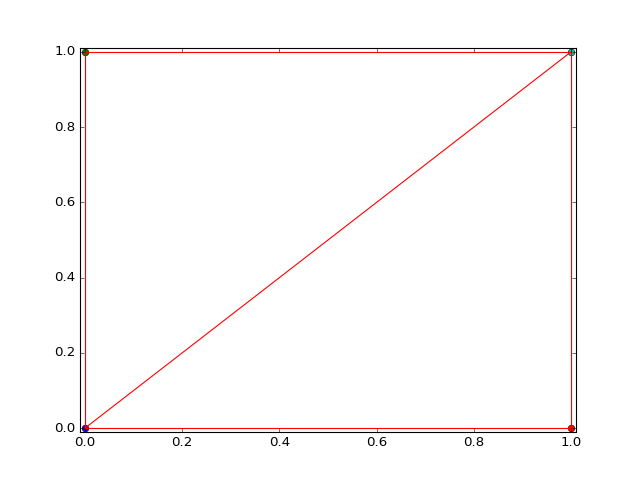

In [136]:
HC.plot_graph()

Initial complex generation
==

<IPython.core.display.Javascript object>


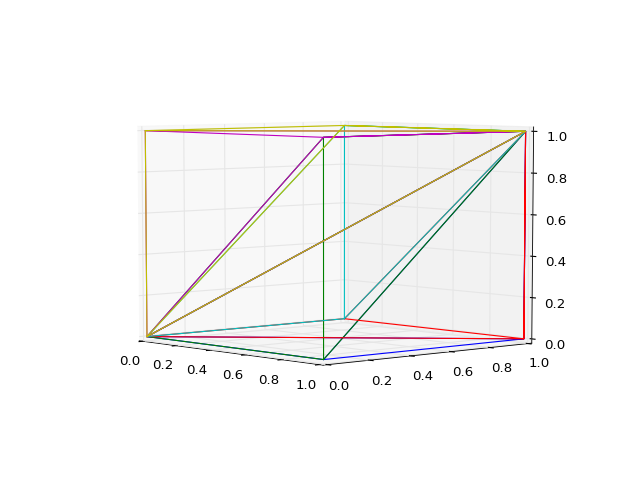

<IPython.core.display.Javascript object>


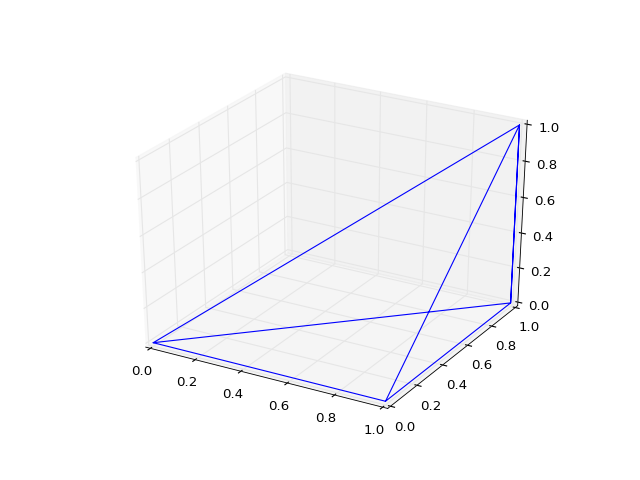

In [132]:
S = HC.n_cube(3, printout=False)
HC.plot_complex_3dim(S)
HC.plot_complex_3dim([S[0]])

Dev work
==

Index set I = [[0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1]]
Vertices V = [[0, 0], [1, 1], [0, 1], [1, 0]]
Simplices S = [[], [[0, 1], [1, 2], [0, 2], [1, 3], [0, 3]], [[0, 1, 2], [0, 1, 3]]]


<IPython.core.display.Javascript object>


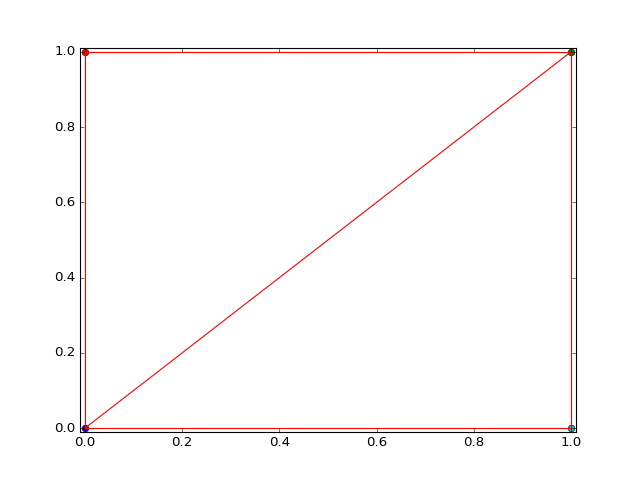

In [134]:
HC = Complex()
HC.I
HC.generate_vertex([0, 0])  # 0
HC.generate_vertex([1, 1])  # 1

# generate first edge
HC.generate_simplex([0, 1], k=1)

#----
# Move down once in first dimension:
HC.generate_vertex([0, 1])  # 2

# generate new edge between 1 and (new vertex)
HC.generate_simplex([1, HC.i_current[0] ]
                 , k=1)

# Move back to 0: New edge
HC.generate_simplex([0, HC.i_current[0] ], k=1)

# Finally get a k=2 simplex
# Generate k=2 simplex
HC.generate_simplex([0, 1, HC.i_current[0]], k=2)

#----
# Starting from V_1 = [1, 1], move down in the second dimension:
HC.generate_vertex([1, 0])  # 2

# generate new edge between 1 and (new vertex)
HC.generate_simplex([1, HC.i_current[0] ]
                 , k=1)

# Move back to 0: New edge
HC.generate_simplex([0, HC.i_current[0] ], k=1)

# Finally get a k=2 simplex
# Generate k=2 faces
HC.generate_simplex([0, 1, HC.i_current[0]], k=2)

# Print resulting structure
HC.print_complex()
HC.plot_graph()

In [133]:
from itertools import product
import itertools
import numpy
dim = 3

def generate_vertices(dim=3):
    print(list(product([0, 1], repeat=dim)))
    #vectorlist = list(product([0, 1], repeat=dim))
    vectors = numpy.array(list(product([0, 1], repeat=dim)))
    vectors, vectors[0], vectors.shape
    print(vectors.shape)
    return vectors

#vectors = numpy.array(list(product([0, 1], [0, 1], [0, 1]))) 
#print(list(product([0, 1], [0, 1], [0, 1])))
#print(list(product([0, 1], repeat=3)))
#vectors, vectors[0], vectors[3**2 - 2]
#vectors[3**2 - 2]
V = generate_vertices(dim)

#vectors = numpy.array(list(product([0, 1], repeat=6)))
#vectors, vectors[0], vectors.shape
V, V[1:-1,:]

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
(8, 3)


(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]), array([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0]]))